# Callbacks

> State's callbacks and variables

In [13]:
#| default_exp callbacks

In [14]:
#|export
from dataclasses import dataclass

In [37]:
#|export
from pysal.lib import weights
from pysal.explore import esda
import itertools
import fastcore.all as fc
import numpy as np
from scipy.spatial import KDTree

import warnings
warnings.filterwarnings("ignore", category=UserWarning, message="The weights matrix is not fully connected")

In [33]:
#| hide
from trufl.utils import gridder
from trufl.sampler import Sampler
import pandas as pd

red, black = '#BF360C', '#263238'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## States

In [25]:
#|export
@dataclass
class Variable:
    "State variable"
    name: str
    value: float

In [18]:
#|export
class Callback(): pass

In [19]:
#|export
class State:
    def __init__(self, measurements, cbs): fc.store_attr()
        
    def get(self, loc_id, as_numpy=False):
        variables = self.run_cbs(loc_id)
        if as_numpy:
            return (np.array([v.name for v in variables]), 
                    np.array([v.value for v in variables]))
        else:
            return variables

    def expand_to_k_nearest(self, subset_measurements, k=5):
        tree = KDTree(self.measurements.geometry.apply(lambda p: (p.x, p.y)).tolist());
        _, indices = tree.query(subset_measurements.geometry.apply(lambda p: (p.x, p.y)).tolist(), k=k)
        return self.measurements.iloc[indices.flatten()].reset_index(drop=True)
        
    def _flatten(self, variables):
        "Flatten list of variables potentially containing both scalar and tuples."
        return list(itertools.chain(*(v if isinstance(v, tuple) else (v,) 
                                      for v in variables)))
    def run_cbs(self, loc_id):
        variables = []
        for cb in self.cbs:
            variables.append(cb(loc_id, self))
        return self._flatten(variables)

In [20]:
#|export
class MaxCB(Callback):
    def __call__(self, loc_id, state): 
        return Variable(
            'Max', 
            np.max(state.measurements[state.measurements.loc_id == loc_id]['value'].values))

In [21]:
#|export
class MinCB(Callback):
    def __call__(self, loc_id, state): 
        return Variable(
            'Min', 
            np.min(state.measurements[state.measurements.loc_id == loc_id]['value'].values))

In [22]:
#|export
class StdCB(Callback):
    def __call__(self, loc_id, state): 
        return Variable(
            'Standard Deviation', 
            np.std(state.measurements[state.measurements.loc_id == loc_id]['value'].values))

In [23]:
#|export
class CountCB(Callback):
    def __call__(self, loc_id, state): 
        return Variable(
            'Count', 
            len(state.measurements[state.measurements.loc_id == loc_id]['value'].values))

In [46]:
#|export
class MoranICB(Callback):
    def __init__(self, k=5): fc.store_attr()

    def _weights(self, measurements):
        w = weights.KNN.from_dataframe(measurements, k=self.k)
        w.transform = "R" # Row-standardization
        return w
        
    def __call__(self, loc_id, state): 
        subset = state.measurements[state.measurements.loc_id == loc_id];
        expanded_measurements = state.expand_to_k_nearest(subset, k=self.k)
        moran = esda.moran.Moran(expanded_measurements['value'], self._weights(expanded_measurements))
        return Variable('Moran.I', moran.I), Variable('Moran_p_sim', moran.p_sim)

In [51]:
fname_raster = 'files/ground-truth-01-4326-simulated.tif'
gdf_grid = gridder(fname_raster, nrows=10, ncols=10)

sampler = Sampler(fname_raster)
n_planned = np.random.randint(1, high=100, size=len(gdf_grid), dtype=int)
loc_ids = gdf_grid.loc_id.values

samples_t0 = []
for loc_id, n in zip(loc_ids, n_planned):    
    sampling_locs = gdf_grid.loc[gdf_grid.loc_id == loc_id].sample_points(n)
    gdf_samples = sampler.sample(sampling_locs)
    samples_t0.append(gdf_samples)

gdf_samples_t0 = pd.concat(samples_t0)

In [52]:
state = State(gdf_samples_t0, [MaxCB(), MinCB(), StdCB(), CountCB(), MoranICB(k=5)])

In [49]:
state.get(0, as_numpy=False)

[Variable(name='Max', value=0.14659424),
 Variable(name='Min', value=0.116223834),
 Variable(name='Standard Deviation', value=0.011539617),
 Variable(name='Count', value=5),
 Variable(name='Moran.I', value=0.516103423324934),
 Variable(name='Moran_p_sim', value=0.001)]

In [50]:
state.get(0, as_numpy=True)

(array(['Max', 'Min', 'Standard Deviation', 'Count', 'Moran.I',
        'Moran_p_sim'], dtype='<U18'),
 array([1.46594241e-01, 1.16223834e-01, 1.15396166e-02, 5.00000000e+00,
        5.16103423e-01, 1.00000000e-03]))

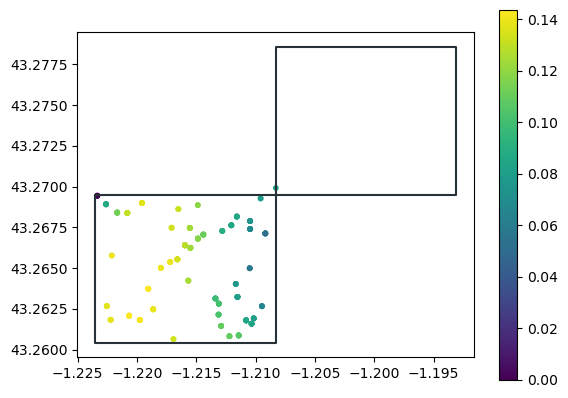

In [44]:
subset = state.measurements[state.measurements.loc_id == 0]; subset.head()

expanded_gpd = state.expand_to_k_nearest(subset, k=5)
ax = expanded_gpd.plot(column='value', s=10, legend=True)
gdf_grid[gdf_grid.loc_id.isin(expanded_gpd.loc_id.unique())].boundary.plot(color=black, ax=ax);

In [15]:
#| hide
import nbdev; nbdev.nbdev_export()